# 4. Ensemble_XGBoostGPU
Kaggle score: 

Conclusion: 即使是只有两个结果，进行简单的加权平均，也可以使结果得到提升。本结论还需要进一步的实验验证。

## Run names

In [1]:
import time

project_name = 'ic_furniture2018'
step_name = 'Ensemble_XGBoostGPU'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: ic_furniture2018_Ensemble_XGBoostGPU_20180428_124817


## Important params

In [2]:
import random
statistics_type = 'val_max'

random_num = random.randint(1, 10000)
print('random_num: ', random_num)

random_num:  3577


## Import PKGs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display

import os
import gc
import zipfile
import h5py
import pickle
import math
from PIL import Image
import shutil

from tqdm import tqdm
from multiprocessing import cpu_count
cpu_amount = cpu_count()

from sklearn.metrics import confusion_matrix, accuracy_score

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Project folders

In [4]:
cwd = os.getcwd()
input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')
feature_folder = os.path.join(cwd, 'feature')
post_pca_feature_folder = os.path.join(cwd, 'post_pca_feature')
log_folder = os.path.join(cwd, 'log')
print('input_folder: \t\t\t%s' % input_folder)
print('output_folder: \t\t\t%s' % output_folder)
print('model_folder: \t\t\t%s' % model_folder)
print('feature_folder: \t\t%s' % feature_folder)
print('post_pca_feature_folder: \t%s' % post_pca_feature_folder)
print('log_folder: \t\t\t%s' % log_folder)

org_train_folder = os.path.join(input_folder, 'org_train')
org_val_folder = os.path.join(input_folder, 'org_val')
org_test_folder = os.path.join(input_folder, 'org_test')
train_folder = os.path.join(input_folder, 'data_train')
val_folder = os.path.join(input_folder, 'data_val')
test_folder = os.path.join(input_folder, 'data_test')
test_sub_folder = os.path.join(test_folder, 'test')

if not os.path.exists(post_pca_feature_folder):
    os.mkdir(post_pca_feature_folder)
    print('Create folder: %s' % post_pca_feature_folder)

train_json_file = os.path.join(input_folder, 'train.json')
val_json_file = os.path.join(input_folder, 'validation.json')
test_json_file = os.path.join(input_folder, 'test.json')
print('\ntrain_json_file: \t\t%s' % train_json_file)
print('val_json_file: \t\t\t%s' % val_json_file)
print('test_json_file: \t\t%s' % test_json_file)

train_csv_file = os.path.join(input_folder, 'train.csv')
val_csv_file = os.path.join(input_folder, 'validation.csv')
test_csv_file = os.path.join(input_folder, 'test.csv')
print('\ntrain_csv_file: \t\t%s' % train_csv_file)
print('val_csv_file: \t\t\t%s' % val_csv_file)
print('test_csv_file: \t\t\t%s' % test_csv_file)

sample_submission_csv_file = os.path.join(input_folder, 'sample_submission_randomlabel.csv')
print('\nsample_submission_csv_file: \t%s' % sample_submission_csv_file)

input_folder: 			/data1/kaggle/imaterialist-challenge-furniture-2018/input
output_folder: 			/data1/kaggle/imaterialist-challenge-furniture-2018/output
model_folder: 			/data1/kaggle/imaterialist-challenge-furniture-2018/model
feature_folder: 		/data1/kaggle/imaterialist-challenge-furniture-2018/feature
post_pca_feature_folder: 	/data1/kaggle/imaterialist-challenge-furniture-2018/post_pca_feature
log_folder: 			/data1/kaggle/imaterialist-challenge-furniture-2018/log

train_json_file: 		/data1/kaggle/imaterialist-challenge-furniture-2018/input/train.json
val_json_file: 			/data1/kaggle/imaterialist-challenge-furniture-2018/input/validation.json
test_json_file: 		/data1/kaggle/imaterialist-challenge-furniture-2018/input/test.json

train_csv_file: 		/data1/kaggle/imaterialist-challenge-furniture-2018/input/train.csv
val_csv_file: 			/data1/kaggle/imaterialist-challenge-furniture-2018/input/validation.csv
test_csv_file: 			/data1/kaggle/imaterialist-challenge-furniture-2018/input/test.csv


## Preview data

In [5]:
train_csv = pd.read_csv(train_csv_file)
print('train_csv.shape is {0}.'.format(train_csv.shape))
display(train_csv.head(2))

val_csv = pd.read_csv(val_csv_file)
print('val_csv.shape is {0}.'.format(val_csv.shape))
display(val_csv.head(2))

test_csv = pd.read_csv(test_csv_file)
print('test_csv.shape is {0}.'.format(test_csv.shape))
display(test_csv.head(2))

test_csv = pd.read_csv(test_csv_file)
print('test_csv.shape is {0}.'.format(test_csv.shape))
display(test_csv.head(2))

sample_submission_csv = pd.read_csv(sample_submission_csv_file)
print('sample_submission_csv.shape is {0}.'.format(sample_submission_csv.shape))
display(sample_submission_csv.head(2))

train_csv.shape is (194828, 3).


,image_id,label_id,url
0,1,5,https://img13.360buyimg.com/imgzone/jfs/t2857/...
1,2,5,http://www.tengdakeli.cn/350/timg01/uploaded/i...


val_csv.shape is (6400, 3).


,image_id,label_id,url
0,1,38,http://www.ghs.net/public/images/fb/3d/51/3beb...
1,2,63,https://img.alicdn.com/imgextra/TB2chFei9YH8KJ...


test_csv.shape is (12800, 2).


,image_id,url
0,1,https://img13.360buyimg.com/imgzone/jfs/t13174...
1,2,http://img35.ddimg.cn/79/22/1258168705-1_u.jpg


test_csv.shape is (12800, 2).


,image_id,url
0,1,https://img13.360buyimg.com/imgzone/jfs/t13174...
1,2,http://img35.ddimg.cn/79/22/1258168705-1_u.jpg


sample_submission_csv.shape is (12800, 2).


,id,predicted
0,1,57
1,2,74


In [6]:
train_id = train_csv['image_id']
train_label_id = train_csv['label_id']

id_2_train_label_id_dict = dict(zip(train_id, train_label_id))
print('len(id_2_train_label_id_dict)=%d' % len(id_2_train_label_id_dict))

index = 0
print('id: %s, \tlandmark_id:%s' % (train_id[index], id_2_train_label_id_dict[train_id[index]]))
index = 1
print('id: %s, \tlandmark_id:%s' % (train_id[index], id_2_train_label_id_dict[train_id[index]]))

image_file = '%s_%s.jpg' % (train_id[index], id_2_train_label_id_dict[train_id[index]])
print(image_file)

len(id_2_train_label_id_dict)=194828
id: 1, 	landmark_id:5
id: 2, 	landmark_id:5
2_5.jpg


In [7]:
val_id = val_csv['image_id']
val_label_id = val_csv['label_id']

id_2_val_label_id_dict = dict(zip(val_id, val_label_id))
print('len(id_2_val_label_id_dict)=%d' % len(id_2_val_label_id_dict))

index = 0
print('id: %s, \tlandmark_id:%s' % (val_id[index], id_2_val_label_id_dict[val_id[index]]))
index = 1
print('id: %s, \tlandmark_id:%s' % (val_id[index], id_2_val_label_id_dict[val_id[index]]))

image_file = '%s_%s.jpg' % (val_id[index], id_2_val_label_id_dict[val_id[index]])
print(image_file)

len(id_2_val_label_id_dict)=6400
id: 1, 	landmark_id:38
id: 2, 	landmark_id:63
2_63.jpg


In [8]:
test_id = test_csv['image_id']

index = 0
print('id: %s' % (test_id[index]))
index = 1
print('id: %s' % (test_id[index]))

image_file = '%s.jpg' % (test_id[index])
print(image_file)

id: 1
id: 2
2.jpg


## Data Generator

In [9]:
from keras.preprocessing.image import ImageDataGenerator

test_gen = ImageDataGenerator()
data_test_path = os.path.join(input_folder, 'data_test')

image_size = 299
width = height = 299
target_size = (width, height)
batch_size = 128

test_generator = test_gen.flow_from_directory(data_test_path, target_size, shuffle=False, batch_size=batch_size)

Using TensorFlow backend.


Found 12652 images belonging to 1 classes.


## Load predict probability files

In [10]:
ori_proba_files = [
    { 'file_name': 'proba_ic_furniture2018_Train-Predict_Mix3model_20180415_053404_7941.p'},
    { 'file_name': 'proba_ic_furniture2018_Train-Predict_Mix3model_20180415_061203_7987.p'},
    { 'file_name': 'proba_ic_furniture2018_Train-Predict_Mix3model_20180415_070425_8115.p'},
    { 'file_name': 'proba_ic_furniture2018_Train-Predict_Mix3model_20180415_071659_8120.p'},
    { 'file_name': 'proba_ic_furniture2018_Train-Predict_Mix3model_20180415_072816_8131.p'},
    { 'file_name': 'proba_ic_furniture2018_Train-Predict_Mix3model_20180415_075023_8175.p'},
    { 'file_name': 'proba_ic_furniture2018_Train-Predict_Mix3model_20180415_080533_8136.p'},
    { 'file_name': 'proba_ic_furniture2018_Train-Predict_Mix3model_20180415_081948_8214.p'},
    { 'file_name': 'proba_ic_furniture2018_TrainPredict_FineTune_20180417_170937_8341.p', 'kaggle_score': 0.17812},
    { 'file_name': 'proba_ic_furniture2018_TrainPredict_FineTune_20180418_130955_8303.p', 'kaggle_score': 0.17890},
    { 'file_name': 'proba_ic_furniture2018_TrainPredict_FineTune_20180422_041707_8300.p', 'kaggle_score': 0.17994},
    { 'file_name': 'proba_ic_furniture2018_TrainPredict_FineTune_20180423_134043_8426.p', 'kaggle_score': 0.17395},
    { 'file_name': 'proba_ic_furniture2018_TrainPredict_FineTune_20180424_143948_8278.p', 'kaggle_score': 0.19479},
    { 'file_name': 'proba_ic_furniture2018_TrainPredict_FineTune_20180427_122315_8392.p', 'kaggle_score': 0.18203},
]

for file in ori_proba_files:
    if os.path.exists(os.path.join(model_folder, file['file_name'])):
        print('File exists: %s' % file['file_name'])
    else:
        print('***File do not exists: %s' % file['file_name'])

File exists: proba_ic_furniture2018_Train-Predict_Mix3model_20180415_053404_7941.p
File exists: proba_ic_furniture2018_Train-Predict_Mix3model_20180415_061203_7987.p
File exists: proba_ic_furniture2018_Train-Predict_Mix3model_20180415_070425_8115.p
File exists: proba_ic_furniture2018_Train-Predict_Mix3model_20180415_071659_8120.p
File exists: proba_ic_furniture2018_Train-Predict_Mix3model_20180415_072816_8131.p
File exists: proba_ic_furniture2018_Train-Predict_Mix3model_20180415_075023_8175.p
File exists: proba_ic_furniture2018_Train-Predict_Mix3model_20180415_080533_8136.p
File exists: proba_ic_furniture2018_Train-Predict_Mix3model_20180415_081948_8214.p
File exists: proba_ic_furniture2018_TrainPredict_FineTune_20180417_170937_8341.p
File exists: proba_ic_furniture2018_TrainPredict_FineTune_20180418_130955_8303.p
File exists: proba_ic_furniture2018_TrainPredict_FineTune_20180422_041707_8300.p
File exists: proba_ic_furniture2018_TrainPredict_FineTune_20180423_134043_8426.p
File exists:

In [11]:
%%time
def save_proba(y_train_proba, y_train, y_val_proba, y_val, y_test_proba, test_filenames, file_name):
    test_filenames = [n.encode('utf8') for n in test_filenames]
    print(test_filenames[:10])
    if os.path.exists(file_name):
        os.remove(file_name)
        print('File removed: \t%s' % file_name)
    with h5py.File(file_name) as h:
        h.create_dataset('y_train_proba', data=y_train_proba)
        h.create_dataset('y_train', data=y_train)
        h.create_dataset('y_val_proba', data=y_val_proba)
        h.create_dataset('y_val', data=y_val)
        h.create_dataset('y_test_proba', data=y_test_proba)
        h.create_dataset('test_filenames', data=test_filenames)
    print('File saved: %s' % file_name)

def load_proba(file_name):
    with h5py.File(file_name, 'r') as h:
        y_train_proba = np.array(h['y_train_proba'])
        y_train = np.array(h['y_train'])
        y_val_proba = np.array(h['y_val_proba'])
        y_val = np.array(h['y_val'])
        y_test_proba = np.array(h['y_test_proba'])
        test_filenames = np.array(h['test_filenames'])
    print('File loaded: %s' % file_name)
    test_filenames = [n.decode('utf8') for n in test_filenames]
#     print(test_filenames[:10])
    return y_train_proba, y_train, y_val_proba, y_val, y_test_proba, test_filenames

def get_acc(y_pred, y_proba):
    max_indexes = np.argmax(y_proba, -1)
    return accuracy_score(y_pred ,max_indexes)


y_train_probas = []
y_trains = []
y_val_probas = []
y_vas = []
y_test_probas = []
for file in ori_proba_files:
    y_proba_file = os.path.join(model_folder, file['file_name'])
    y_train_proba, y_train, y_val_proba, y_val, y_test_proba, test_filenames = load_proba(y_proba_file)
#     print(y_train_proba.shape)
#     print(y_train.shape)
#     print(y_val_proba.shape)
#     print(y_val.shape)
#     print(y_test_proba.shape)
#     print(len(test_filenames))
    y_train_probas.append(y_train_proba)
    y_val_probas.append(y_val_proba)
    y_test_probas.append(y_test_proba)
    file['train_acc'] = get_acc(y_train, y_train_proba)
    file['val_acc'] = get_acc(y_val, y_val_proba)

for f in ori_proba_files:
    print(f['file_name'], '%.4f' % f['train_acc'], '%.4f' % f['val_acc'])

File loaded: /data1/kaggle/imaterialist-challenge-furniture-2018/model/proba_ic_furniture2018_Train-Predict_Mix3model_20180415_053404_7941.p
File loaded: /data1/kaggle/imaterialist-challenge-furniture-2018/model/proba_ic_furniture2018_Train-Predict_Mix3model_20180415_061203_7987.p
File loaded: /data1/kaggle/imaterialist-challenge-furniture-2018/model/proba_ic_furniture2018_Train-Predict_Mix3model_20180415_070425_8115.p
File loaded: /data1/kaggle/imaterialist-challenge-furniture-2018/model/proba_ic_furniture2018_Train-Predict_Mix3model_20180415_071659_8120.p
File loaded: /data1/kaggle/imaterialist-challenge-furniture-2018/model/proba_ic_furniture2018_Train-Predict_Mix3model_20180415_072816_8131.p
File loaded: /data1/kaggle/imaterialist-challenge-furniture-2018/model/proba_ic_furniture2018_Train-Predict_Mix3model_20180415_075023_8175.p
File loaded: /data1/kaggle/imaterialist-challenge-furniture-2018/model/proba_ic_furniture2018_Train-Predict_Mix3model_20180415_080533_8136.p
File loaded: 

## Get basic statistical data

In [12]:
ensemble_res = {}

In [13]:
%%time
def get_mean(probas):
    probas_newaxises = []
    for p in probas:
        print('*', end='')
        probas_newaxises.append(p[:, :, np.newaxis])
    probas_newaxis = np.concatenate(probas_newaxises, axis=-1)
    probas_mean = np.mean(probas_newaxis, axis=-1)
    print('probas_mean.shape: \t', probas_mean.shape)
    return probas_mean

ensemble_res['train_mean'] = get_acc(y_train ,get_mean(y_train_probas))
ensemble_res['val_mean'] = get_acc(y_val ,get_mean(y_val_probas))
y_test_proba_mean = get_mean(y_test_probas)

# print(ensemble_res)

**************probas_mean.shape: 	 (191261, 128)
**************probas_mean.shape: 	 (6301, 128)
**************probas_mean.shape: 	 (12652, 128)
CPU times: user 3.24 s, sys: 324 ms, total: 3.57 s
Wall time: 3.56 s


In [14]:
%%time
def get_min(probas):
    probas_newaxises = []
    for p in probas:
        print('*', end='')
        probas_newaxises.append(p[:, :, np.newaxis])
    probas_newaxis = np.concatenate(probas_newaxises, axis=-1)
    probas_min = np.min(probas_newaxis, axis=-1)
    print('probas_min.shape: \t', probas_min.shape)
    return probas_min

ensemble_res['train_min'] = get_acc(y_train ,get_min(y_train_probas))
ensemble_res['val_min'] = get_acc(y_val ,get_min(y_val_probas))
y_test_proba_min = get_min(y_test_probas)

# print(ensemble_res)

**************probas_min.shape: 	 (191261, 128)
**************probas_min.shape: 	 (6301, 128)
**************probas_min.shape: 	 (12652, 128)
CPU times: user 4.08 s, sys: 280 ms, total: 4.36 s
Wall time: 4.35 s


In [15]:
%%time
def get_max(probas):
    probas_newaxises = []
    for p in probas:
        print('*', end='')
        probas_newaxises.append(p[:, :, np.newaxis])
    probas_newaxis = np.concatenate(probas_newaxises, axis=-1)
    probas_max = np.max(probas_newaxis, axis=-1)
    print('probas_max.shape: \t', probas_max.shape)
    return probas_max

ensemble_res['train_max'] = get_acc(y_train ,get_max(y_train_probas))
ensemble_res['val_max'] = get_acc(y_val ,get_max(y_val_probas))
y_test_proba_max = get_max(y_test_probas)

# print(ensemble_res)

**************probas_max.shape: 	 (191261, 128)
**************probas_max.shape: 	 (6301, 128)
**************probas_max.shape: 	 (12652, 128)
CPU times: user 3.9 s, sys: 320 ms, total: 4.22 s
Wall time: 4.21 s


In [16]:
%%time
def get_median(probas):
    probas_newaxises = []
    for p in probas:
        print('*', end='')
        probas_newaxises.append(p[:, :, np.newaxis])
    probas_newaxis = np.concatenate(probas_newaxises, axis=-1)
    probas_median = np.median(probas_newaxis, axis=-1)
    print('probas_median.shape: \t', probas_median.shape)
    return probas_median

ensemble_res['train_median'] = get_acc(y_train ,get_median(y_train_probas))
ensemble_res['val_median'] = get_acc(y_val ,get_median(y_val_probas))
y_test_proba_median = get_median(y_test_probas)

# print(ensemble_res)

**************probas_median.shape: 	 (191261, 128)
**************probas_median.shape: 	 (6301, 128)
**************probas_median.shape: 	 (12652, 128)
CPU times: user 8.66 s, sys: 676 ms, total: 9.34 s
Wall time: 9.32 s


In [17]:
for i, key in enumerate(ensemble_res.keys()):
    if i % 2 == 0:
        print('%s  \t%.4f' % (key, ensemble_res[key]), end='\t')
    else:
        print('%s  \t%.4f' % (key, ensemble_res[key]))

train_mean  	0.9714	val_mean  	0.8627
train_min  	0.9736	val_min  	0.8553
train_max  	0.9749	val_max  	0.8562
train_median  	0.9677	val_median  	0.8570


## XGBoost Ensemble

In [18]:
y_train_probas_sta = np.concatenate([
    get_mean(y_train_probas), 
    get_min(y_train_probas), 
    get_max(y_train_probas), 
    get_median(y_train_probas)
], axis=-1)
print(y_train_probas_sta.shape)

y_val_probas_sta = np.concatenate([
    get_mean(y_val_probas), 
    get_min(y_val_probas), 
    get_max(y_val_probas), 
    get_median(y_val_probas)
], axis=-1)
print(y_val_probas_sta.shape)

y_test_probas_sta = np.concatenate([
    get_mean(y_test_probas), 
    get_min(y_test_probas), 
    get_max(y_test_probas), 
    get_median(y_test_probas)
], axis=-1)
print(y_test_probas_sta.shape)

**************probas_mean.shape: 	 (191261, 128)
**************probas_min.shape: 	 (191261, 128)
**************probas_max.shape: 	 (191261, 128)
**************probas_median.shape: 	 (191261, 128)
(191261, 512)
**************probas_mean.shape: 	 (6301, 128)
**************probas_min.shape: 	 (6301, 128)
**************probas_max.shape: 	 (6301, 128)
**************probas_median.shape: 	 (6301, 128)
(6301, 512)
**************probas_mean.shape: 	 (12652, 128)
**************probas_min.shape: 	 (12652, 128)
**************probas_max.shape: 	 (12652, 128)
**************probas_median.shape: 	 (12652, 128)
(12652, 512)


In [19]:
y_train_probas_sta = y_train_probas_sta.copy()
y_train = y_train.copy()
y_val_probas_sta = y_val_probas_sta.copy()
y_val = y_val.copy()

In [20]:
%%time

import xgboost as xgb
from sklearn.metrics import roc_auc_score


clf = xgb.XGBClassifier(
    max_depth=10, 
    learning_rate=0.1, 
    n_estimators=5000, 
    silent=False, 
    objective='gpu:multi:softmax', 
    booster='gbtree', 
    n_jobs=1, 
    nthread=None, 
    gamma=0, 
    min_child_weight=1, 
    max_delta_step=0, 
    subsample=0.5, 
    colsample_bytree=0.5, 
    colsample_bylevel=0.5, 
    reg_alpha=0.09, 
    reg_lambda=0.9, 
#     scale_pos_weight=10, 
    base_score=0.5, 
    random_state=random_num, 
    seed=None, 
    missing=None,
    # booster params
    num_boost_round=50,
    early_stopping_rounds=20,
    tree_method='gpu_hist',
#     predictor='gpu_predictor',
    eval_metric=['merror', 'mlogloss']
)

clf.fit(
    y_train_probas_sta, 
    y_train,
#     sample_weight=None, 
    eval_set=[(y_train_probas_sta, y_train), (y_val_probas_sta, y_val)], 
#     eval_metric=['mlogloss', 'error'], 
    early_stopping_rounds=20, 
#     verbose=False, 
#     xgb_model=None
)


[0]	validation_0-merror:0.045854	validation_0-mlogloss:0.751566	validation_1-merror:0.173623	validation_1-mlogloss:1.41937
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.040066	validation_0-mlogloss:0.6505	validation_1-merror:0.16299	validation_1-mlogloss:1.29914
[2]	validation_0-merror:0.037164	validation_0-mlogloss:0.579481	validation_1-merror:0.160451	validation_1-mlogloss:1.21821
[3]	validation_0-merror:0.034785	validation_0-mlogloss:0.522107	validation_1-merror:0.160609	validation_1-mlogloss:1.15985
[4]	validation_0-merror:0.032432	validation_0-mlogloss:0.471401	validation_1-merror:0.159975	validation_1-mlogloss:1.10671
[5]	validation_0-merror:0.030623	validation_0-mlogloss:0.428455	validation_1-merror:0.15807	validation_1-mlogloss:1.06421
[6]	validation_0-merror:0.029128	validation_0-mlogloss:0.390593	validation_1-merror:0.156483	valida

In [21]:
y_train_pred = clf.predict(y_train_probas_sta)
acc_train = accuracy_score(y_train, y_train_pred)
print('acc_train: %.4f' % acc_train)

y_val_pred = clf.predict(y_val_probas_sta)
acc_val = accuracy_score(y_val, y_val_pred)
print('acc_val:   %.4f' % acc_val)

acc_train: 0.9977
acc_val:   0.8597


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


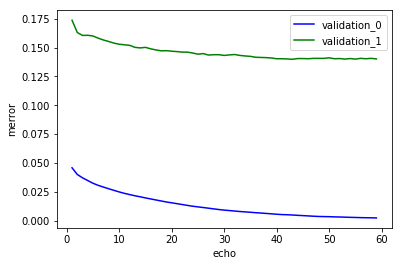

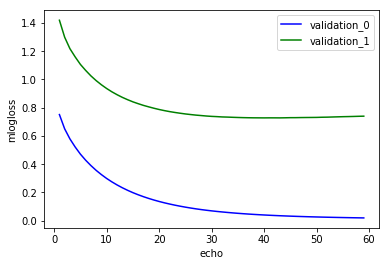

In [22]:
evals_result = clf.evals_result()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
# print(evals_result)

validation_0_key = list(evals_result.keys())[0]
metric_0_key = list(evals_result[validation_0_key].keys())[0]
n_round = len(evals_result[validation_0_key][metric_0_key])

x = list(range(1, n_round + 1))
for metric_key in evals_result[validation_0_key].keys():
    plt.xlabel('echo')
    plt.ylabel(metric_key)
    for i, val_key in enumerate(evals_result.keys()):
        plt.plot(x, evals_result[val_key][metric_key], colors[i])
    plt.legend(labels = list(evals_result.keys()), loc = 'best')
    plt.show()

## Predict

In [23]:
y_test_pred = clf.predict(y_test_probas_sta)
print(y_test_pred.shape)

(12652,)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [24]:
%%time

# if statistics_type == 'val_mean':
#     max_indexes = np.argmax(y_test_proba_mean, -1)
# elif statistics_type == 'val_min':
#     max_indexes = np.argmax(y_test_proba_min, -1)
# elif statistics_type == 'val_max':
#     max_indexes = np.argmax(y_test_proba_max, -1)
# else: 
#     # statistics_type == 'val_median'
#     max_indexes = np.argmax(y_test_proba_median, -1)
# print(xg_test_pred.shape)

test_dict = {}
for pair in zip(test_filenames, y_test_pred):
    image_name, indx = pair[0], int(pair[1])
    image_name = image_name.split('/')[-1]
    image_id = int(image_name.split('.')[0])
#     print(pair[0], image_name, image_id, indx, indx+1, type(image_id), type(indx))
    test_dict[image_id] = indx + 1

#确认图片的id是否能与ImageDataGenerator()对应上
for name in test_filenames[:10]:
    image_name = name.split('/')[-1]
    image_id = int(image_name.split('.')[0])
#     print('%s\t%s\t%s' % (name, image_id, test_dict[image_id]))

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 19.3 ms


In [25]:
display(sample_submission_csv.head(2))

,id,predicted
0,1,57
1,2,74


In [26]:
%%time
len_sample_submission_csv = len(sample_submission_csv)
print('len(len_sample_submission_csv)=%d' % len_sample_submission_csv)
count = 0
for i in range(len_sample_submission_csv):
    image_id = int(sample_submission_csv.iloc[i, 0])
    if image_id in test_dict:
        pred_label = test_dict[image_id]
#         print('%s\t%s' % (image_id, pred_label))
        sample_submission_csv.iloc[i, 1] = pred_label
    else:
#         print('%s\t%s' % (image_id, 20))
        sample_submission_csv.iloc[i, 1] = 20 # 属于20的类最多，所以全都设置成这个类，可能会比设置成其他得到的结果好
    count += 1
    if count % 1000 == 0:
        print(int(count/1000), end=' ')
display(sample_submission_csv.head(2))

len(len_sample_submission_csv)=12800
1 2 3 4 5 6 7 8 9 10 11 12 

,id,predicted
0,1,12
1,2,61


CPU times: user 11.2 s, sys: 1.12 s, total: 12.3 s
Wall time: 12.3 s


In [27]:
print(list(set(sample_submission_csv['predicted'])))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128]


In [28]:
run_name_acc = run_name + '_' + str(int(ensemble_res[statistics_type]*10000)).zfill(4)
print(run_name_acc)

ic_furniture2018_Ensemble_XGBoostGPU_20180428_124817_8562


In [29]:
pred_file = os.path.join(output_folder, 'pred_%s.csv' % run_name_acc)
sample_submission_csv.to_csv(pred_file, index=None)

In [30]:
print('Time cost: %.2f s' % (time.time() - t0))
print(statistics_type)

print(run_name_acc)
print('Done !')

Time cost: 347.81 s
val_max
ic_furniture2018_Ensemble_XGBoostGPU_20180428_124817_8562
Done !
